# Load packages and data

In [25]:
import nflreadpy as nfl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [26]:
def load_schedule(season):
    """Load NFL schedule for a given season"""
    print(f"Loading {season} NFL schedule...")
    df = nfl.load_schedules([season])
    df = df.to_pandas()
    return df

In [27]:
def filter_regular_season(df):
    """Keep only completed regular season games"""
    print("Filtering to regular season games...")
    
    # Only regular season games that have been played
    regular_season = df[df['game_type'] == 'REG'].copy()
    regular_season = regular_season[regular_season['result'].notna()].copy()
    
    print(f"Found {len(regular_season)} completed games")
    return regular_season

In [28]:
def initialize_elo_ratings(df, initial_elo=1500):
    """Initializing all teams at starting elo rating"""
    print(f"\nInitializing Elo ratings at {initial_elo}...")

    # Get all unique teams (both home and away)
    home_teams = df['home_teams'].unique()
    away_teams = df['away_teams'].unique()
    all_teams = set[Any](list[Any](home_teams) + list[Any](away_teams))

    # Intialize dictionary
    elo_ratings = {team: initial_elo for team in all_teams}

    return elo_ratings

# Elo Rating System

In [29]:
def initialize_elo_ratings(df, initial_elo=1500):
    """Give every team a starting Elo rating"""
    print(f"\nInitializing Elo ratings at {initial_elo}...")
    
    # Get all unique teams
    home_teams = df['home_team'].unique()
    away_teams = df['away_team'].unique()
    all_teams = set(list(home_teams) + list(away_teams))
    
    # Create dictionary: team name -> Elo rating
    elo_ratings = {team: initial_elo for team in all_teams}
    
    print(f"Initialized {len(elo_ratings)} teams")
    return elo_ratings


def compute_win_probability(elo_home, elo_away, hfa, is_neutral=False):
    """
    Calculate probability that home team wins
    
    Formula: P(win) = 1 / (1 + 10^(-elo_diff/400))
    This is the standard Elo probability formula
    """
    # Add home field advantage (unless neutral site)
    advantage = 0 if is_neutral else hfa
    
    # Calculate Elo difference
    elo_diff = elo_home - elo_away + advantage
    
    # Convert to probability using logistic curve
    p_home_win = 1 / (1 + 10 ** (-elo_diff / 400))
    
    return p_home_win


def update_elo_ratings(elo_ratings, df, k_factor=20, hfa=55):
    """
    Update Elo ratings based on game results
    
    How it works:
    1. Before each game, predict who should win
    2. After game, adjust ratings based on actual result
    3. Bigger upsets = bigger rating changes
    """
    print(f"\nUpdating Elo ratings (K={k_factor}, HFA={hfa})...")
    
    # Sort games by date to process in order
    df = df.sort_values('gameday').copy()
    
    for idx, row in df.iterrows():
        home_team = row['home_team']
        away_team = row['away_team']
        home_score = row['home_score']
        away_score = row['away_score']
        
        # Get current Elo ratings
        elo_home = elo_ratings[home_team]
        elo_away = elo_ratings[away_team]
        
        # Predict who should win
        p_home_win = compute_win_probability(elo_home, elo_away, hfa)
        
        # Who actually won? (1 = home win, 0 = away win)
        actual_result = 1 if home_score > away_score else 0
        
        # Calculate rating change
        # If favorite wins: small change
        # If underdog wins: big change
        delta = k_factor * (actual_result - p_home_win)
        
        # Update ratings
        elo_ratings[home_team] = elo_home + delta
        elo_ratings[away_team] = elo_away - delta
    
    print("✓ Elo ratings updated!")
    return elo_ratings


In [30]:
PLAYOFF_SEEDS = {
    "AFC": {
        1: "DEN",
        2: "NE",
        3: "JAX",
        4: "PIT",
        5: "HOU",
        6: "BUF",
        7: "LAC"
    },
    "NFC": {
        1: "SEA",
        2: "CHI",
        3: "PHI",
        4: "CAR",
        5: "LA",
        6: "SF",
        7: "GB"
    }
}

# Game Simulation

In [31]:
def simulate_game(team_home, team_away, elo_dict, hfa, is_neutral=False):
    """
    Simulate one game using Monte Carlo method
    
    Returns the winner
    """
    # Get team ratings
    elo_home = elo_dict[team_home]
    elo_away = elo_dict[team_away]
    
    # Calculate win probability
    p_home_win = compute_win_probability(elo_home, elo_away, hfa, is_neutral)
    
    # Flip a weighted coin
    # Random number between 0 and 1
    random_number = np.random.random()
    
    # If random number < probability, home team wins
    if random_number < p_home_win:
        return team_home
    else:
        return team_away

# Playoff Rounds

In [32]:
def simulate_wild_card(conference, seeds, elo_dict, hfa):
    """Wild Card Round: 3 games"""
    winners = []
    
    # Matchups: 2 vs 7, 3 vs 6, 4 vs 5
    # Higher seed hosts (plays at home)
    matchups = [(2, 7), (3, 6), (4, 5)]
    
    for seed_home, seed_away in matchups:
        team_home = seeds[seed_home]
        team_away = seeds[seed_away]
        winner = simulate_game(team_home, team_away, elo_dict, hfa)
        winners.append(winner)
    
    return winners


def get_seed_number(team, seeds):
    """Helper: Find what seed number a team is"""
    for seed_num, team_name in seeds.items():
        if team_name == team:
            return seed_num
    return 99  # Should never happen


def simulate_divisional(conference, wc_winners, seeds, elo_dict, hfa):
    """Divisional Round: 2 games, #1 seed enters"""
    winners = []
    
    # Get seed numbers for wild card winners
    wc_seeds = [get_seed_number(team, seeds) for team in wc_winners]
    wc_seeds.sort()  # [lowest number, middle, highest number]
    
    # Game 1: #1 seed vs worst remaining team
    team_1 = seeds[1]
    team_worst = seeds[wc_seeds[-1]]  # Highest seed number
    winner1 = simulate_game(team_1, team_worst, elo_dict, hfa)
    winners.append(winner1)
    
    # Game 2: Two best remaining wild card teams
    team_best_wc = seeds[wc_seeds[0]]
    team_mid_wc = seeds[wc_seeds[1]]
    winner2 = simulate_game(team_best_wc, team_mid_wc, elo_dict, hfa)
    winners.append(winner2)
    
    return winners


def simulate_conference_championship(conference, div_winners, seeds, elo_dict, hfa):
    """Conference Championship: 1 game, higher seed hosts"""
    
    # Find seed numbers
    seed1 = get_seed_number(div_winners[0], seeds)
    seed2 = get_seed_number(div_winners[1], seeds)
    
    # Lower seed number = higher seed = home team
    if seed1 < seed2:
        team_home = div_winners[0]
        team_away = div_winners[1]
    else:
        team_home = div_winners[1]
        team_away = div_winners[0]
    
    winner = simulate_game(team_home, team_away, elo_dict, hfa)
    return winner


def simulate_super_bowl(afc_champ, nfc_champ, elo_dict, hfa):
    """Super Bowl: Neutral site (no home field advantage)"""
    winner = simulate_game(afc_champ, nfc_champ, elo_dict, hfa, is_neutral=True)
    return winner

# Full Playoff Bracket

In [33]:
def simulate_one_bracket(elo_dict, hfa):
    """Simulate one complete playoff bracket"""
    
    # AFC Playoffs
    afc_seeds = PLAYOFF_SEEDS["AFC"]
    afc_wc_winners = simulate_wild_card("AFC", afc_seeds, elo_dict, hfa)
    afc_div_winners = simulate_divisional("AFC", afc_wc_winners, afc_seeds, elo_dict, hfa)
    afc_champ = simulate_conference_championship("AFC", afc_div_winners, afc_seeds, elo_dict, hfa)
    
    # NFC Playoffs
    nfc_seeds = PLAYOFF_SEEDS["NFC"]
    nfc_wc_winners = simulate_wild_card("NFC", nfc_seeds, elo_dict, hfa)
    nfc_div_winners = simulate_divisional("NFC", nfc_wc_winners, nfc_seeds, elo_dict, hfa)
    nfc_champ = simulate_conference_championship("NFC", nfc_div_winners, nfc_seeds, elo_dict, hfa)
    
    # Super Bowl
    champion = simulate_super_bowl(afc_champ, nfc_champ, elo_dict, hfa)
    
    return champion


# Monte Carlo Simulation 

In [34]:
def run_monte_carlo(elo_dict, hfa, n_simulations=10000):
    """
    Run the simulation many times to find probabilities
    
    Why? Each simulation is random. Running 10000 times gives us
    the probability each team wins.
    """
    print(f"\n{'='*60}")
    print(f"Running {n_simulations:,} Monte Carlo simulations...")
    print(f"{'='*60}")
    
    # Count how many times each team wins
    champion_counts = {}
    
    for i in range(n_simulations):
        # Progress update
        if (i + 1) % 100 == 0:
            print(f"  Progress: {i + 1:,} / {n_simulations:,} ({(i+1)/n_simulations*100:.0f}%)")
        
        # Simulate one complete playoff
        champion = simulate_one_bracket(elo_dict, hfa)
        
        # Count this result
        if champion in champion_counts:
            champion_counts[champion] += 1
        else:
            champion_counts[champion] = 1
    
    print(f"\n✓ Completed all {n_simulations:,} simulations!\n")
    
    return champion_counts

# Visualization

In [35]:
def plot_results(champion_counts, n_simulations):
    """Create bar chart of Super Bowl probabilities"""
    
    # Convert counts to percentages
    champion_pct = {team: (count / n_simulations) * 100 
                    for team, count in champion_counts.items()}
    
    # Sort by probability (highest first)
    sorted_teams = sorted(champion_pct.items(), key=lambda x: x[1], reverse=True)
    
    teams = [t[0] for t in sorted_teams]
    percentages = [t[1] for t in sorted_teams]
    
    # Create bar chart
    plt.figure(figsize=(14, 7))
    bars = plt.bar(teams, percentages, color='#013369', edgecolor='black', linewidth=1.5)
    
    # Color the top team differently
    bars[0].set_color('#D50A0A')
    
    # Add percentage labels on bars
    for bar, pct in zip(bars, percentages):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{pct:.1f}%',
                ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    plt.xlabel('Team', fontsize=13, fontweight='bold')
    plt.ylabel('Super Bowl Win Probability (%)', fontsize=13, fontweight='bold')
    plt.title(f'Super Bowl LIX Champion Predictions\nBased on {n_simulations:,} Monte Carlo Simulations', 
              fontsize=15, fontweight='bold', pad=20)
    plt.ylim(0, max(percentages) * 1.15)
    plt.grid(axis='y', alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.show()
    
    # Print results table
    print("\n" + "="*70)
    print(f"{'SUPER BOWL LIX CHAMPION PROBABILITIES':^70}")
    print("="*70)
    print(f"{'Rank':<8} {'Team':<10} {'Probability':<20} {'Times Won':<20}")
    print("-"*70)
    
    for rank, (team, pct) in enumerate(sorted_teams, 1):
        count = champion_counts[team]
        print(f"{rank:<8} {team:<10} {pct:>6.2f}%              {count:>6,} / {n_simulations:,}")
    
    print("="*70)
    print(f"\nFavorite: {sorted_teams[0][0]} ({sorted_teams[0][1]:.1f}% chance)")
    print(f"Underdog: {sorted_teams[-1][0]} ({sorted_teams[-1][1]:.1f}% chance)")

# Main Execution

In [36]:
def main():
    """Main function - runs everything"""
    
    # Configuration
    SEASON = 2024
    INITIAL_ELO = 1500
    K_FACTOR = 20          # How much ratings change per game
    HOME_FIELD_ADVANTAGE = 55  # Points added for home team
    N_SIMULATIONS = 1000   # Number of times to simulate playoffs
    
    print("\n" + "="*70)
    print("NFL PLAYOFF PREDICTOR - MONTE CARLO SIMULATION")
    print("="*70)
    
    # Step 1: Load data
    schedule = load_schedule(SEASON)
    regular_season = filter_regular_season(schedule)
    
    # Step 2: Calculate Elo ratings from season results
    elo_ratings = initialize_elo_ratings(regular_season, INITIAL_ELO)
    elo_ratings = update_elo_ratings(elo_ratings, regular_season, K_FACTOR, HOME_FIELD_ADVANTAGE)
    
    # Show top teams by Elo
    print("\nTop 10 Teams by Elo Rating:")
    print("-" * 40)
    sorted_elo = sorted(elo_ratings.items(), key=lambda x: x[1], reverse=True)
    for i, (team, rating) in enumerate(sorted_elo[:10], 1):
        print(f"{i:2d}. {team:3s}: {rating:.0f}")
    
    # Step 3: Run Monte Carlo simulation
    champion_counts = run_monte_carlo(elo_ratings, HOME_FIELD_ADVANTAGE, N_SIMULATIONS)
    
    # Step 4: Visualize results
    plot_results(champion_counts, N_SIMULATIONS)


NFL PLAYOFF PREDICTOR - MONTE CARLO SIMULATION
Loading 2024 NFL schedule...
Filtering to regular season games...
Found 272 completed games

Initializing Elo ratings at 1500...
Initialized 32 teams

Updating Elo ratings (K=20, HFA=55)...
✓ Elo ratings updated!

Top 10 Teams by Elo Rating:
----------------------------------------
 1. DET: 1608
 2. KC : 1603
 3. PHI: 1588
 4. MIN: 1588
 5. BUF: 1570
 6. BAL: 1563
 7. WAS: 1556
 8. LAC: 1541
 9. GB : 1539
10. DEN: 1530

Running 1,000 Monte Carlo simulations...
  Progress: 100 / 1,000 (10%)
  Progress: 200 / 1,000 (20%)
  Progress: 300 / 1,000 (30%)
  Progress: 400 / 1,000 (40%)
  Progress: 500 / 1,000 (50%)
  Progress: 600 / 1,000 (60%)
  Progress: 700 / 1,000 (70%)
  Progress: 800 / 1,000 (80%)
  Progress: 900 / 1,000 (90%)
  Progress: 1,000 / 1,000 (100%)

✓ Completed all 1,000 simulations!



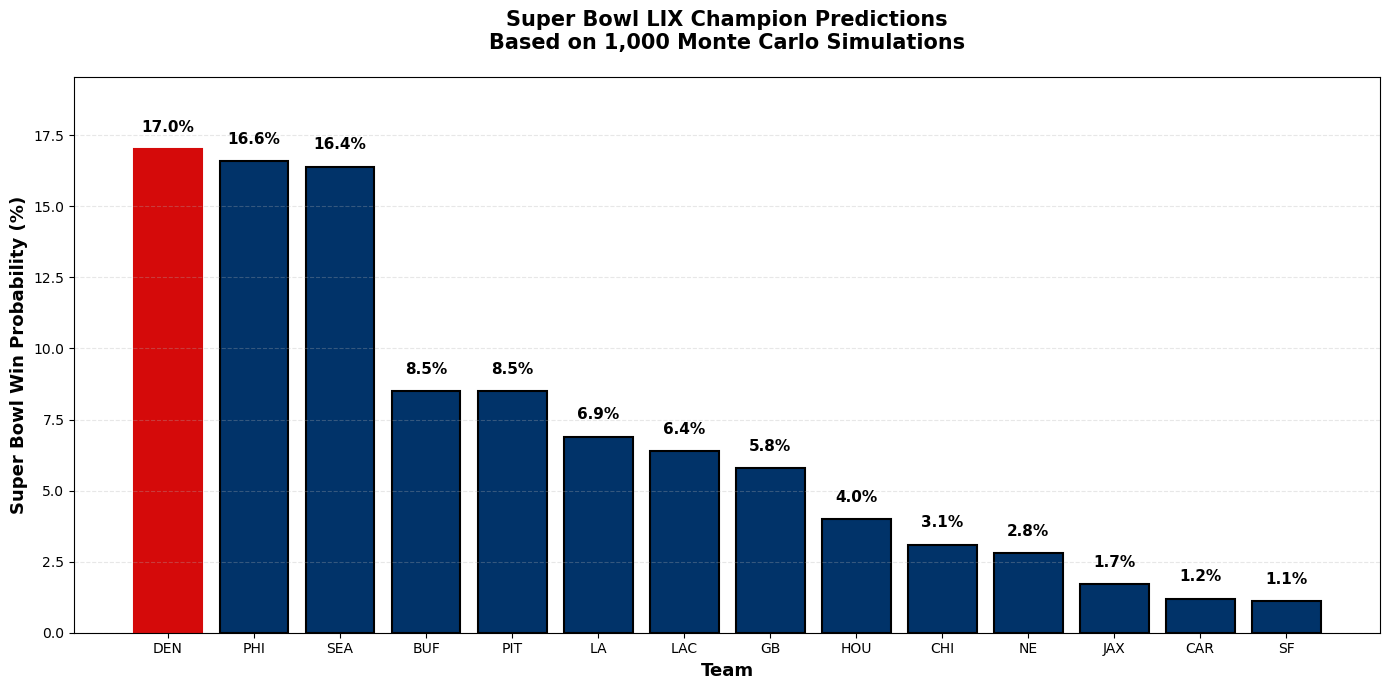


                SUPER BOWL LIX CHAMPION PROBABILITIES                 
Rank     Team       Probability          Times Won           
----------------------------------------------------------------------
1        DEN         17.00%                 170 / 1,000
2        PHI         16.60%                 166 / 1,000
3        SEA         16.40%                 164 / 1,000
4        BUF          8.50%                  85 / 1,000
5        PIT          8.50%                  85 / 1,000
6        LA           6.90%                  69 / 1,000
7        LAC          6.40%                  64 / 1,000
8        GB           5.80%                  58 / 1,000
9        HOU          4.00%                  40 / 1,000
10       CHI          3.10%                  31 / 1,000
11       NE           2.80%                  28 / 1,000
12       JAX          1.70%                  17 / 1,000
13       CAR          1.20%                  12 / 1,000
14       SF           1.10%                  11 / 1,000

Favorite: 

In [37]:
import matplotlib.pyplot as plt
if __name__ == "__main__":
    main()